In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import networkx as nx
import glob
import json
import matplotlib.pyplot as plt
import re
import gc

In [2]:
meta_df = pd.read_csv('metadata.csv',usecols=["cord_uid", "sha", "title","abstract","publish_time","authors","journal","pdf_json_files"])
meta_df.dropna(subset = ['abstract'],axis = 0, inplace = True)
meta_df.drop_duplicates(subset=['sha','title','abstract'],keep ='last',inplace=True)
meta_df.head()

/Users/yianding/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3071: DtypeWarning: Columns (1,15) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,cord_uid,sha,title,abstract,publish_time,authors,journal,pdf_json_files
0,ug7v899j,d1aafb70c066a2068b02786f8929fd9c900897fb,Clinical features of culture-proven Mycoplasma...,OBJECTIVE: This retrospective chart review des...,2001-07-04,"Madani, Tariq A; Al-Ghamdi, Aisha A",BMC Infect Dis,document_parses/pdf_json/d1aafb70c066a2068b027...
1,02tnwd4m,6b0567729c2143a66d737eb0a2f63f2dce2e5a7d,Nitric oxide: a pro-inflammatory mediator in l...,Inflammatory diseases of the respiratory tract...,2000-08-15,"Vliet, Albert van der; Eiserich, Jason P; Cros...",Respir Res,document_parses/pdf_json/6b0567729c2143a66d737...
2,ejv2xln0,06ced00a5fc04215949aa72528f2eeaae1d58927,Surfactant protein-D and pulmonary host defense,Surfactant protein-D (SP-D) participates in th...,2000-08-25,"Crouch, Erika C",Respir Res,document_parses/pdf_json/06ced00a5fc04215949aa...
3,2b73a28n,348055649b6b8cf2b9a376498df9bf41f7123605,Role of endothelin-1 in lung disease,Endothelin-1 (ET-1) is a 21 amino acid peptide...,2001-02-22,"Fagan, Karen A; McMurtry, Ivan F; Rodman, David M",Respir Res,document_parses/pdf_json/348055649b6b8cf2b9a37...
4,9785vg6d,5f48792a5fa08bed9f56016f4981ae2ca6031b32,Gene expression in epithelial cells in respons...,Respiratory syncytial virus (RSV) and pneumoni...,2001-05-11,"Domachowske, Joseph B; Bonville, Cynthia A; Ro...",Respir Res,document_parses/pdf_json/5f48792a5fa08bed9f560...


In [4]:
meta_df["abstract"][1]

'Inflammatory diseases of the respiratory tract are commonly associated with elevated production of nitric oxide (NO•) and increased indices of NO• -dependent oxidative stress. Although NO• is known to have anti-microbial, anti-inflammatory and anti-oxidant properties, various lines of evidence support the contribution of NO• to lung injury in several disease models. On the basis of biochemical evidence, it is often presumed that such NO• -dependent oxidations are due to the formation of the oxidant peroxynitrite, although alternative mechanisms involving the phagocyte-derived heme proteins myeloperoxidase and eosinophil peroxidase might be operative during conditions of inflammation. Because of the overwhelming literature on NO• generation and activities in the respiratory tract, it would be beyond the scope of this commentary to review this area comprehensively. Instead, it focuses on recent evidence and concepts of the presumed contribution of NO• to inflammatory diseases of the lun

In [7]:
print(meta_df.shape)
meta_df.isnull().sum()

(345536, 8)


cord_uid               0
sha               205760
title                 43
abstract               0
publish_time         202
authors             2913
journal            27369
pdf_json_files    205760
dtype: int64

A large number of documents do not have parsed full article available; we will stick to abstract first. Luckily, no abstract is missing.

In [5]:
from tqdm import tqdm
from langdetect import detect
from langdetect import DetectorFactory
DetectorFactory.seed = 77
languages = []
for i in tqdm(range(0,len(meta_df))):
    text = meta_df.iloc[i]['abstract'].split(" ")
    lang = "en"
    try:
        if len(text) > 50:
            lang = detect(" ".join(text[:50]))
        elif len(text) > 0:
            lang = detect(" ".join(text[:len(text)]))
    except Exception as e:
        lang = "unknown"
    languages.append(lang)


100%|██████████| 345536/345536 [20:18<00:00, 283.53it/s]


In [6]:
languages_dict = {}
for lang in set(languages):
    languages_dict[lang] = languages.count(lang)
print(languages_dict)

{'zh-cn': 245, 'ko': 41, 'ru': 14, 'cy': 4, 'pt': 1282, 'fa': 2, 'id': 5, 'ja': 7, 'fi': 3, 'es': 1665, 'hu': 62, 'ca': 21, 'hr': 3, 'sl': 2, 'no': 3, 'unknown': 46, 'uk': 1, 'pl': 1, 'nl': 299, 'zh-tw': 2, 'da': 1, 'vi': 7, 'lt': 2, 'sw': 1, 'de': 906, 'it': 172, 'ro': 13, 'en': 339695, 'et': 2, 'tl': 1, 'af': 8, 'fr': 993, 'tr': 26, 'mk': 1}


In [51]:
lang_df = pd.DataFrame(languages, columns=['lang'])
lang_df['is_en'] = np.where(lang_df['lang'] == 'en', 'en', 'other')
lang_df['count'] = lang_df.groupby('is_en')['is_en'].transform('count')

<BarContainer object of 2 artists>

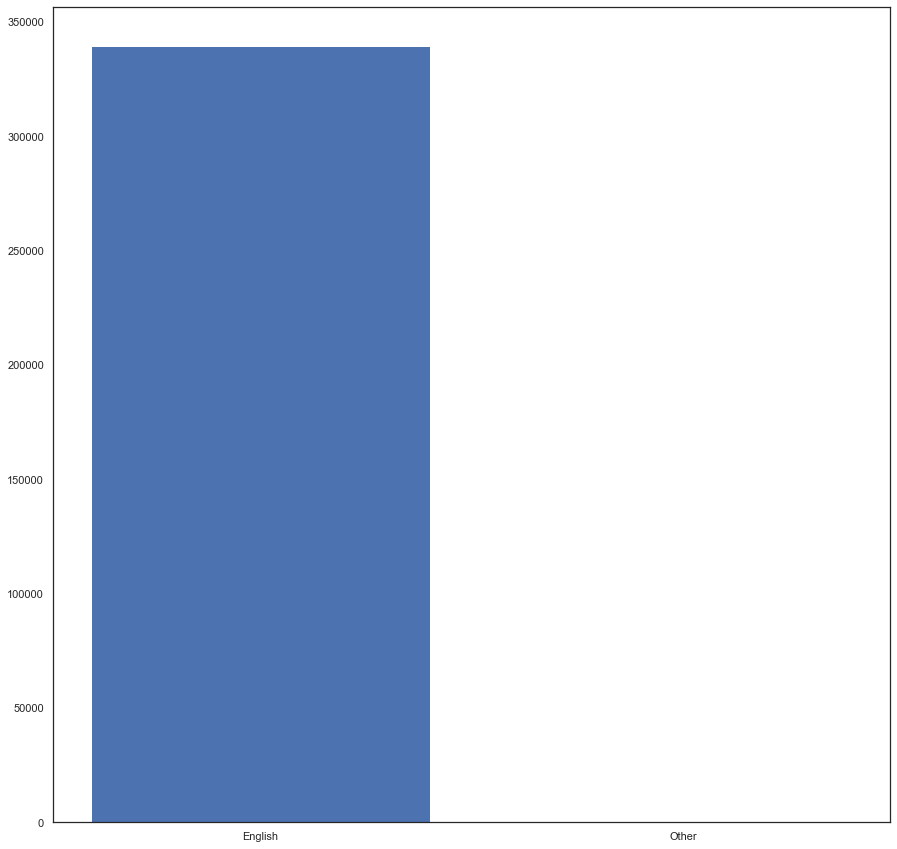

In [72]:
# sns.set_style("white")
# ax = sns.barplot(x="is_en",y = "count",data = lang_df, palette = "Set2")
# sns.despine()
# ax.get_figure().savefig("lang.png")
x = ['English', 'Other']
height = [lang_df['count'][0], 339695-lang_df['count'][0]]
plt.bar(x=x,height = height)
# , title = "English versus Non-English abstarcts distribution"

In [73]:
plt.savefig('lang.png')

<Figure size 1080x1080 with 0 Axes>

We will remove doucments with languages other than English

In [7]:
meta_df['language'] = languages
meta_df = meta_df[meta_df['language'] == 'en'] 
meta_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 339695 entries, 0 to 490902
Data columns (total 9 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   cord_uid        339695 non-null  object
 1   sha             138236 non-null  object
 2   title           339679 non-null  object
 3   abstract        339695 non-null  object
 4   publish_time    339498 non-null  object
 5   authors         336902 non-null  object
 6   journal         313372 non-null  object
 7   pdf_json_files  138236 non-null  object
 8   language        339695 non-null  object
dtypes: object(9)
memory usage: 25.9+ MB


In [8]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
stop = stopwords.words('english')
meta_df['abstract_no_sw'] = meta_df['abstract'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
meta_df['tokenized_abstarct'] = meta_df['abstract_no_sw'].apply(word_tokenize)

<ipython-input-8-6c0482ab5a4b>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meta_df['abstract_no_sw'] = meta_df['abstract'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
<ipython-input-8-6c0482ab5a4b>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meta_df['tokenized_abstarct'] = meta_df['abstract_no_sw'].apply(word_tokenize)


In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer
vec = TfidfVectorizer()
vec_matrix = vec.fit_transform(meta_df['abstract_no_sw'])
vec_matrix

<339695x313406 sparse matrix of type '<class 'numpy.float64'>'
	with 33700257 stored elements in Compressed Sparse Row format>

In [76]:
# vec_matrix = vec_matrix.todense()  

In [10]:
from sklearn.decomposition import TruncatedSVD
pca = TruncatedSVD(n_components=2000)
vec_matrix_pca = pca.fit_transform(vec_matrix)

# from sklearn.decomposition import PCA
# pca = PCA(n_components=0.95, random_state=89)
# vec_matrix_pca= pca.fit_transform(vec_matrix)
# vec_matrix_pca.shape

In [11]:
vec_matrix_pca

array([[ 0.2078373 , -0.04607516,  0.21503086, ..., -0.00991777,
        -0.00081413, -0.00115498],
       [ 0.09077554,  0.03683863, -0.00784308, ...,  0.01052151,
         0.00063128,  0.00065155],
       [ 0.06476872,  0.05195318, -0.01314987, ..., -0.00291408,
        -0.01033869, -0.00368459],
       ...,
       [ 0.26708719, -0.13672982,  0.18186501, ..., -0.00471223,
        -0.00047067, -0.00449633],
       [ 0.05436789,  0.03899899, -0.03618003, ..., -0.00807395,
         0.00480779, -0.00453692],
       [ 0.19520811, -0.05707898,  0.1595848 , ...,  0.03097471,
         0.04139964, -0.03101504]])

In [15]:
from sklearn import metrics
from scipy.spatial.distance import cdist

# run kmeans with many different k
distortions = []
K = range(2, 50)
for k in K:
    k_means = KMeans(n_clusters=k, random_state=77)
    k_means.fit(vec_matrix_pca)
    distortions.append(sum(np.min(cdist(vec_matrix_pca, k_means.cluster_centers_, 'euclidean'), axis=1)) / vec_matrix_pca.shape[0])
X_line = [K[0], K[-1]]
Y_line = [distortions[0], distortions[-1]]

KeyboardInterrupt: 

In [ ]:
# Plot the elbow
plt.plot(K, distortions, 'b-')
plt.plot(X_line, Y_line, 'r')
plt.xlabel('Number of Clusters')
plt.ylabel('SSE')

plt.title('The Elbow Method')
plt.savefig("Elbow Method.png")
plt.show()

In [12]:
from sklearn.cluster import KMeans
abstract10 = KMeans(n_clusters=10, verbose = 0)
abstract10.fit(vec_matrix_pca)

KMeans(n_clusters=10)

In [13]:
meta_df['abstract10'] = abstract10.labels_

<ipython-input-13-2f2d6e416df4>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meta_df['abstract10'] = abstract10.labels_


## t-SNE

In [14]:
from sklearn.manifold import TSNE
tsne = TSNE(verbose=1, perplexity=100, random_state=77)
vec_matrix_embedded = tsne.fit_transform(vec_matrix_pca)

[t-SNE] Computing 301 nearest neighbors...


KeyboardInterrupt: 

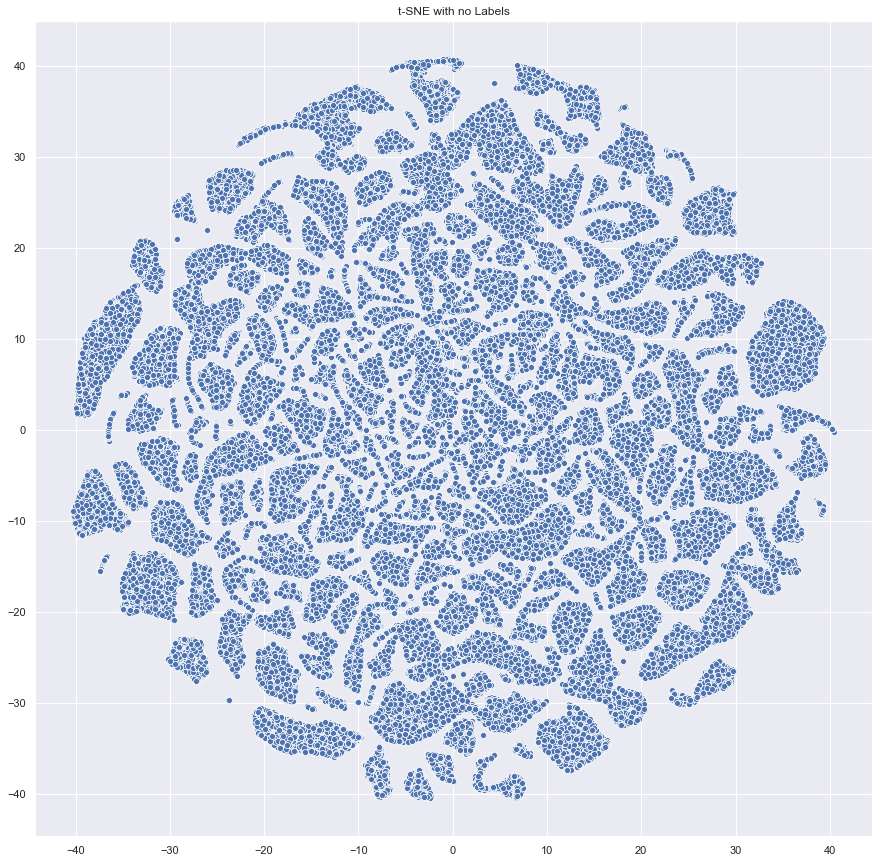

In [21]:
import seaborn as sns

sns.set(rc={'figure.figsize':(15,15)})

palette = sns.color_palette("bright", 1)


sns.scatterplot(vec_matrix_embedded[:,0], vec_matrix_embedded[:,1], palette=palette)
plt.title('t-SNE with no Labels')
plt.savefig("t-sne_covid19.png")
plt.show()

In [ ]:
# sns settings
sns.set(rc={'figure.figsize':(15,15)})

# colors
palette = sns.hls_palette(10)

# plot
sns.scatterplot(vec_matrix_embedded[:,0], vec_matrix_embedded[:,1], hue=meta_df['abstract10'], legend='full', palette=palette)
plt.title('Kmeans results with t-SNE')
plt.savefig("tsne.png")
plt.show()

In [25]:
vec_matrix_embedded.shape
meta_df['abstract10']

0         0
1         9
2         9
3         9
4         6
         ..
490898    7
490899    2
490900    5
490901    9
490902    0
Name: abstract10, Length: 339695, dtype: int32

In [47]:
meta_df

,cord_uid,sha,title,abstract,publish_time,authors,journal,pdf_json_files,tokenized_abstarct,abstract_no_sw,abstract10
0,ug7v899j,d1aafb70c066a2068b02786f8929fd9c900897fb,Clinical features of culture-proven Mycoplasma...,OBJECTIVE: This retrospective chart review des...,2001-07-04,"Madani, Tariq A; Al-Ghamdi, Aisha A",BMC Infect Dis,document_parses/pdf_json/d1aafb70c066a2068b027...,"[OBJECTIVE, :, This, retrospective, chart, rev...",OBJECTIVE: This retrospective chart review des...,4
1,02tnwd4m,6b0567729c2143a66d737eb0a2f63f2dce2e5a7d,Nitric oxide: a pro-inflammatory mediator in l...,Inflammatory diseases of the respiratory tract...,2000-08-15,"Vliet, Albert van der; Eiserich, Jason P; Cros...",Respir Res,document_parses/pdf_json/6b0567729c2143a66d737...,"[Inflammatory, diseases, respiratory, tract, c...",Inflammatory diseases respiratory tract common...,2
2,ejv2xln0,06ced00a5fc04215949aa72528f2eeaae1d58927,Surfactant protein-D and pulmonary host defense,Surfactant protein-D (SP-D) participates in th...,2000-08-25,"Crouch, Erika C",Respir Res,document_parses/pdf_json/06ced00a5fc04215949aa...,"[Surfactant, protein-D, (, SP-D, ), participat...",Surfactant protein-D (SP-D) participates innat...,2
3,2b73a28n,348055649b6b8cf2b9a376498df9bf41f7123605,Role of endothelin-1 in lung disease,Endothelin-1 (ET-1) is a 21 amino acid peptide...,2001-02-22,"Fagan, Karen A; McMurtry, Ivan F; Rodman, David M",Respir Res,document_parses/pdf_json/348055649b6b8cf2b9a37...,"[Endothelin-1, (, ET-1, ), 21, amino, acid, pe...",Endothelin-1 (ET-1) 21 amino acid peptide dive...,2
4,9785vg6d,5f48792a5fa08bed9f56016f4981ae2ca6031b32,Gene expression in epithelial cells in respons...,Respiratory syncytial virus (RSV) and pneumoni...,2001-05-11,"Domachowske, Joseph B; Bonville, Cynthia A; Ro...",Respir Res,document_parses/pdf_json/5f48792a5fa08bed9f560...,"[Respiratory, syncytial, virus, (, RSV, ), pne...",Respiratory syncytial virus (RSV) pneumonia vi...,2
...,...,...,...,...,...,...,...,...,...,...,...
490898,rbemevt2,20b74039ae20e4dfae0a66ff5caa3e00484af24d,Tackling COVID-19 Pandemic through Nanocoating...,Abstract After the eruption of the most deadly...,2020-07-09,"Rai, Pradeep Kumar; Usmani, Zeba; Thakur, Vija...",NaN,document_parses/pdf_json/20b74039ae20e4dfae0a6...,"[Abstract, After, eruption, deadly, influenza,...",Abstract After eruption deadly influenza flu p...,3
490899,6oqwjj93,4420ba48ac1065a1653a8cc8fcee8ce727d44fcd,Loss aversion fails to replicate in the corona...,Loss aversion is a foundational bias and is a ...,2020-07-24,"Sanders, Michael; Stockdale, Emma; Hume, Susan...",Econ Lett,document_parses/pdf_json/4420ba48ac1065a1653a8...,"[Loss, aversion, foundational, bias, natural, ...",Loss aversion foundational bias natural choice...,7
490900,w094r17f,15f169d3b781549c83dc88a9750917e9867593aa,COVID-19 increased the risk of ICU-acquired bl...,PURPOSE: The primary objective of this study w...,2021-01-27,"Buetti, Niccolò; Ruckly, Stéphane; de Montmoll...",Intensive Care Med,document_parses/pdf_json/15f169d3b781549c83dc8...,"[PURPOSE, :, The, primary, objective, study, i...",PURPOSE: The primary objective study investiga...,4
490901,3zvwu5bd,a8dca87fa78f22310ca799b28d6cf90351f33de0,Large Arf1 guanine nucleotide exchange factors...,The Sec7 domain ADP-ribosylation factor (Arf) ...,2009-08-11,"Bui, Quynh Trang; Golinelli-Cohen, Marie-Pierr...",Mol Genet Genomics,document_parses/pdf_json/a8dca87fa78f22310ca79...,"[The, Sec7, domain, ADP-ribosylation, factor, ...",The Sec7 domain ADP-ribosylation factor (Arf) ...,2


Next Steps:
1, Use full article instead of abstract to gain more insights
2, 